In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.core.common import flatten

In [2]:
data_path = '../data/uci_data.xls'

In [3]:
df = pd.read_excel(data_path, header=0, index_col=0, skiprows=1)
df = df.rename(columns={'PAY_0': 'PAY_1'})

In [4]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [5]:
train.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
21754,80000,2,2,2,24,0,0,0,0,0,...,73731,39643,39457,3503,5001,2092,1218,1445,878,0
252,30000,1,2,2,28,0,0,0,0,0,...,25255,22001,0,5006,1244,851,955,0,0,0
22942,180000,2,5,1,44,0,0,-1,-1,-1,...,0,6881,10340,0,850,0,6881,10340,182,0
619,60000,1,1,2,25,0,0,0,0,0,...,39639,39619,39140,2018,1900,2000,1500,1900,2000,0
17091,130000,2,2,2,25,0,0,0,0,0,...,117823,120854,123904,4100,4200,5000,5000,5000,10700,0


# Check for missing data

In [6]:
train.isnull().sum()

LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_1                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

# Check for non valid values

In [7]:
sex_bad = train[~train['SEX'].isin([1,2])]
len(sex_bad.index)

0

In [8]:
edu_bad = train[~(train['EDUCATION'].isin([1, 2, 3, 4]))]
len(edu_bad.index)

277

In [9]:
mar_bad = train[~(train['MARRIAGE'].isin([1, 2, 3]))]
len(mar_bad.index)

45

In [10]:
age_bad = train[(train['AGE']<0) | (train['AGE']>=99)]
len(age_bad.index)

0

In [11]:
# PAY_* fuera de rango
paux = ~(train['PAY_1'].isin([-1,0,1,2,3,4,5,6,7,8,9]))

for i in range(2, 7):
    paux = paux | ~(train['PAY_' + str(i)].isin([-1,0,1,2,3,4,5,6,7,8,9]))

len(train[paux])

5225

# Check for outliers in numerical data

In [12]:
cat = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
num = ['LIMIT_BAL', 'AGE', 
       'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 
       'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

In [13]:
outliers = pd.DataFrame()
for c in num:
    #extract the upper and lower quantiles
    q1 = train[c].quantile(0.25)
    q3 = train[c].quantile(0.75)
    #extract the inter quartile range
    iqr = q3 - q1
    #get the upper and lower bounds
    lower_bound = q1 - 3*iqr
    upper_bound = q3 + 3*iqr
    #extract values outside these bounds 
    o = train[(train[c] <= lower_bound) | (train[c] >= upper_bound)].copy()
    o['outlier_column'] = c
    outliers = pd.concat((outliers, o))

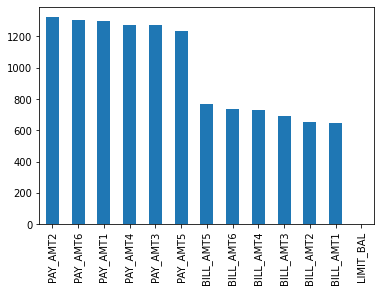

In [14]:
outliers['outlier_column'].value_counts().plot(kind='bar');

It seems like our outliers are divided in two groups: pay ammount and bill ammount

# Get the shape of the data

## Categorical Features

PAY_0 ... PAY_6:
-2: No consumption; -1: Paid in full; 0: The use of revolving credit; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.

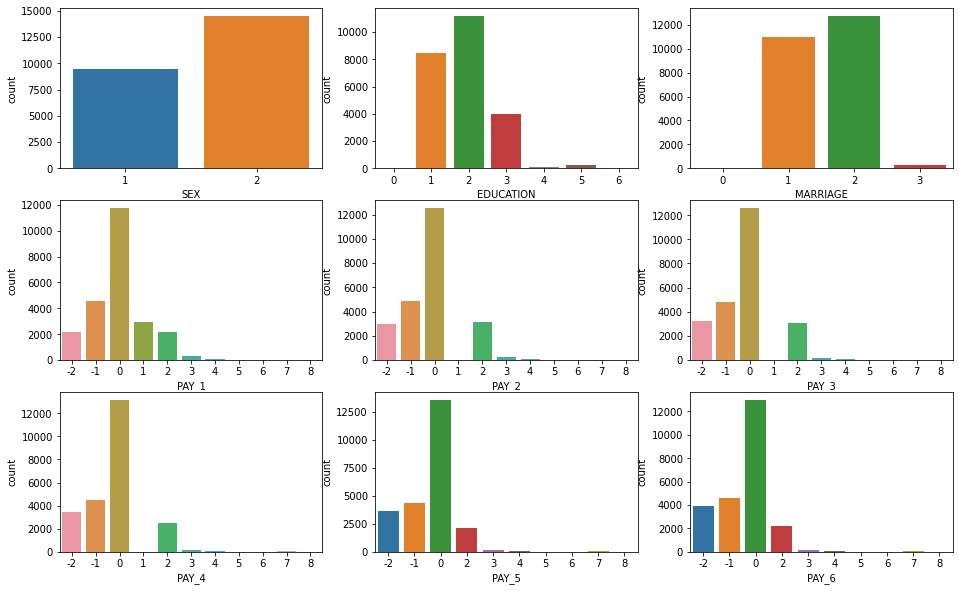

In [16]:
fig, axs = plt.subplots(3, 3, figsize=(16, 10))

for ax,c in zip(list(flatten(axs)), cat):
    sns.countplot(x=c, data=train, ax=ax)

## Numerical Features

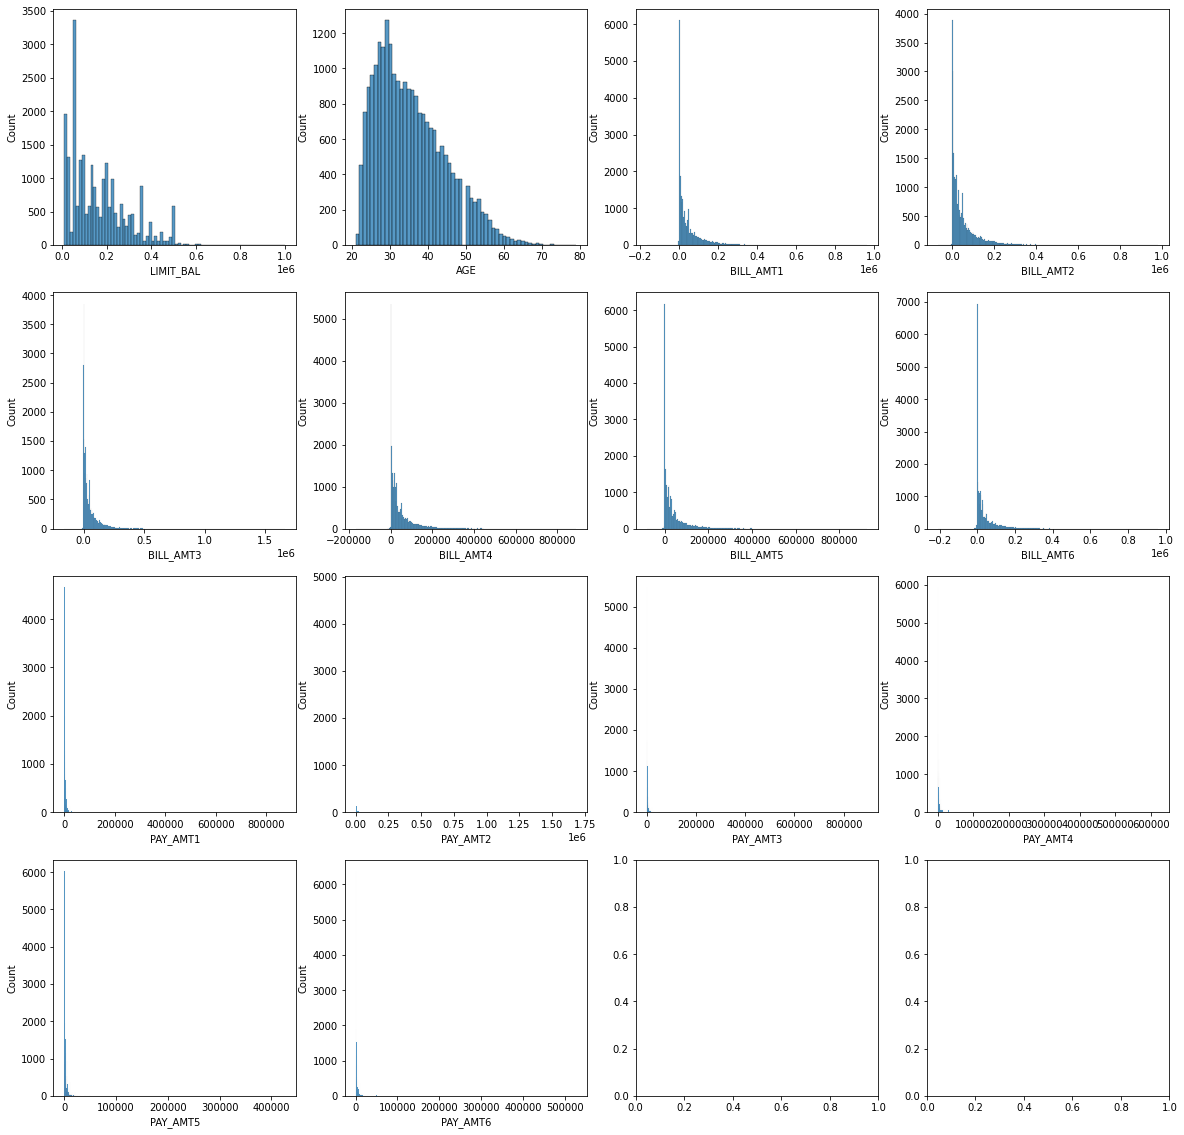

In [18]:
fig, axs = plt.subplots(4, 4, figsize=(20, 20))

for ax,c in zip(list(flatten(axs)), num):
    sns.histplot(x=c, data=train, ax=ax)

# Spot Outliers

It is generally possible for a credit card customer to overpay their bill and temporarily carry a negative balance. E.g., say my bill this month is \\$100 but I pay \\$250. Assuming I have no other recent purchases, my balance will be -\\$150.

As for why a customer might do this, maybe their autopay is set up to pay the same amount every month regardless of balance, maybe they forgot if they paid their bill one month and accidentally paid twice, or maybe they just like to pay down some future expected purchases in advance. Payment behavior like this may not always appear rational, but it is not uncommon. 

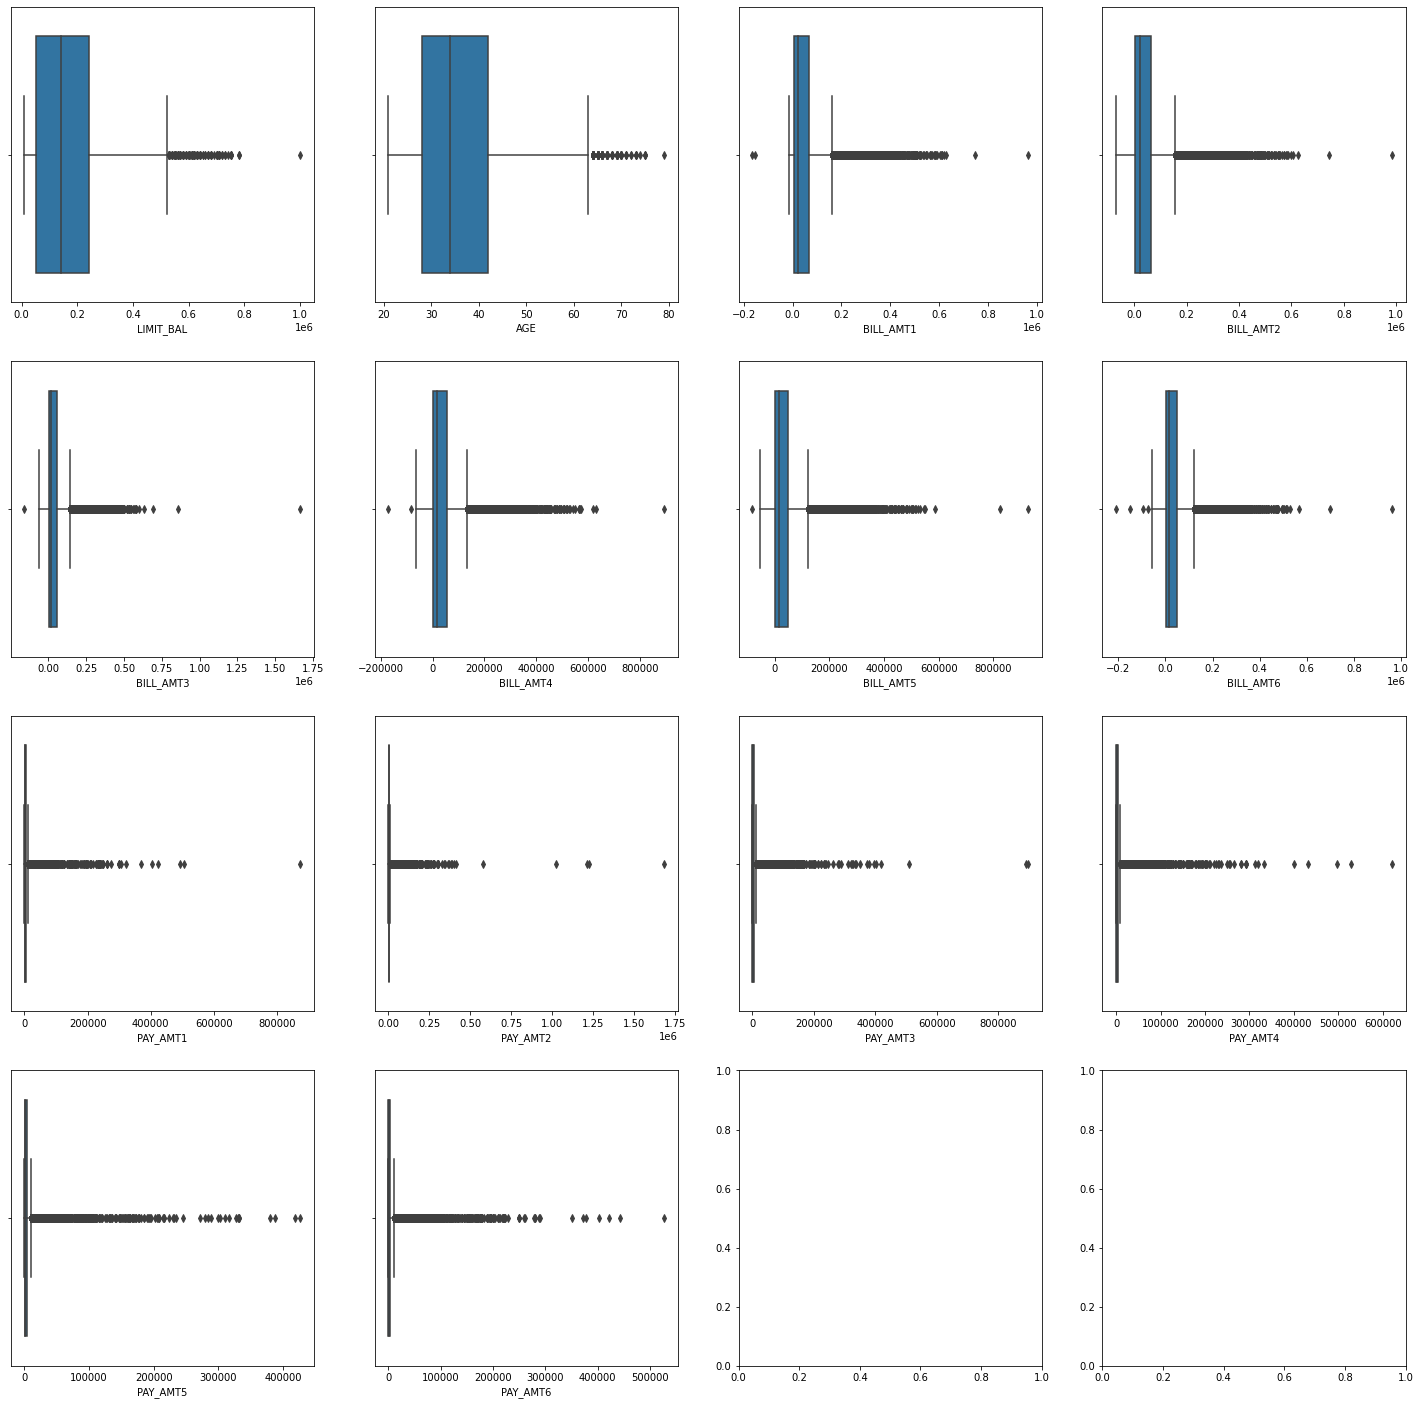

In [20]:
fig, axs = plt.subplots(4, 4, figsize=(25, 25))

for ax,c in zip(list(flatten(axs)), num):
    sns.boxplot(x=c, data=train, ax=ax)

# Identify correlations

<AxesSubplot:>

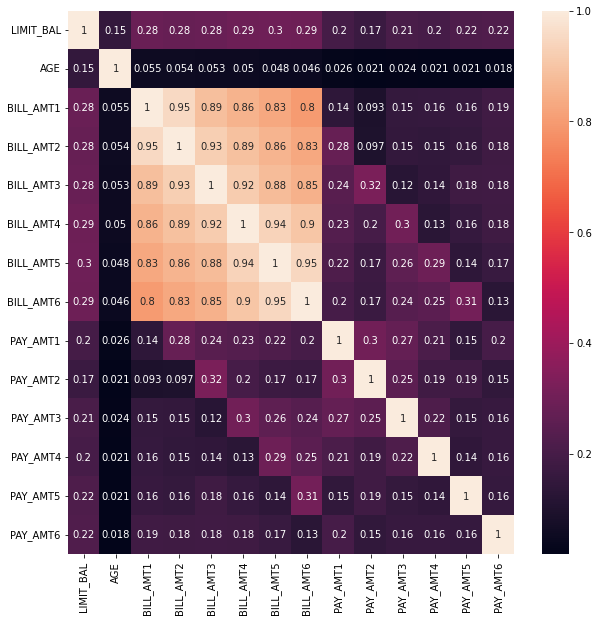

In [22]:
corrMatrix = train[num].corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corrMatrix, annot=True, ax=ax)

## PCA and TSNE Visualizations

In [23]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [54]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(train.drop(columns=['default payment next month']).values)
df2 = pd.DataFrame()
df2['pca-one'] = pca_result[:,0]
df2['pca-two'] = pca_result[:,1] 
df2['pca-three'] = pca_result[:,2]
df2.index = train.index
print('Explained variation: {}'.format(pca.explained_variance_ratio_))


Explained variation: [0.60699934 0.29536756 0.03105447]


In [55]:
df2["default"] = train['default payment next month']

<AxesSubplot:xlabel='pca-one', ylabel='pca-two'>

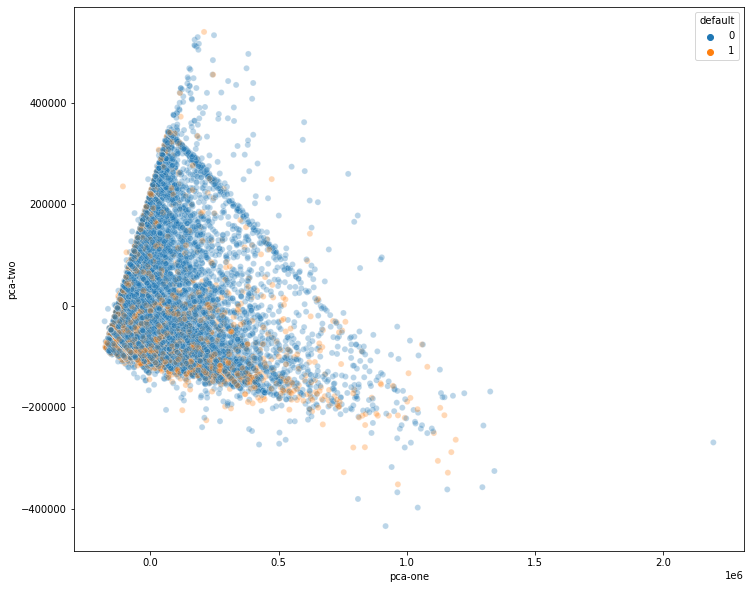

In [58]:
plt.figure(figsize=(12,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="default",    
    data=df2,
    legend="full",
    alpha=0.3
)

<AxesSubplot:xlabel='pca-one', ylabel='pca-three'>

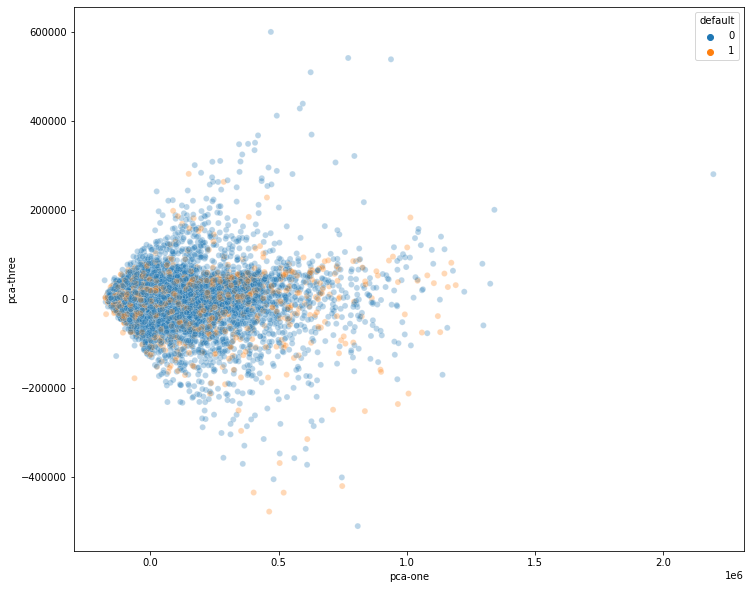

In [59]:
plt.figure(figsize=(12,10))
sns.scatterplot(
    x="pca-one", y="pca-three",
    hue="default",    
    data=df2,
    legend="full",
    alpha=0.3
)

In [60]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(train.drop(columns=['default payment next month']).values)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 24000 samples in 0.001s...
[t-SNE] Computed neighbors for 24000 samples in 9.969s...
[t-SNE] Computed conditional probabilities for sample 1000 / 24000
[t-SNE] Computed conditional probabilities for sample 2000 / 24000
[t-SNE] Computed conditional probabilities for sample 3000 / 24000
[t-SNE] Computed conditional probabilities for sample 4000 / 24000
[t-SNE] Computed conditional probabilities for sample 5000 / 24000
[t-SNE] Computed conditional probabilities for sample 6000 / 24000
[t-SNE] Computed conditional probabilities for sample 7000 / 24000
[t-SNE] Computed conditional probabilities for sample 8000 / 24000
[t-SNE] Computed conditional probabilities for sample 9000 / 24000
[t-SNE] Computed conditional probabilities for sample 10000 / 24000
[t-SNE] Computed conditional probabilities for sample 11000 / 24000
[t-SNE] Computed conditional probabilities for sample 12000 / 24000
[t-SNE] Computed conditional probabilities for sa

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

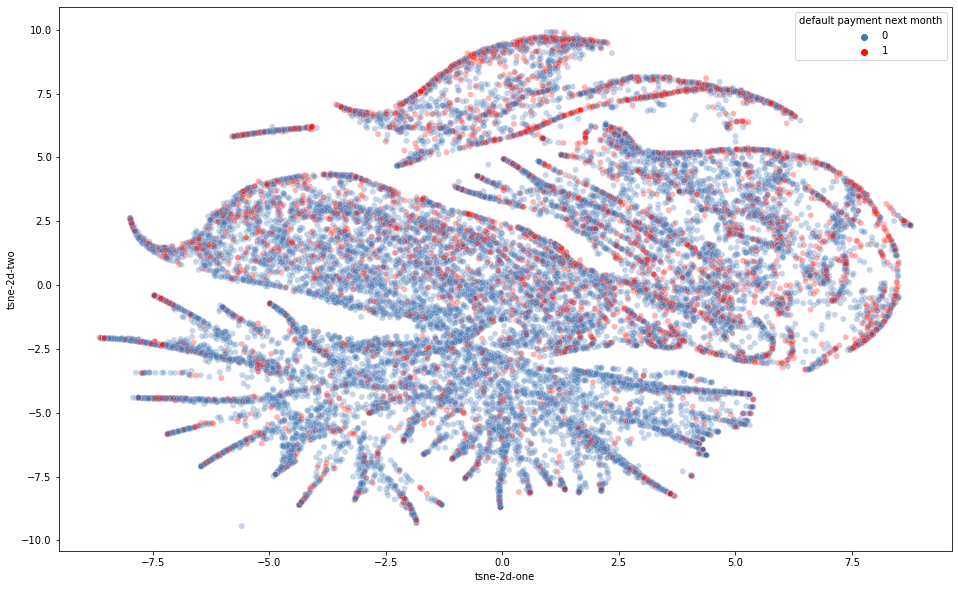

In [68]:
auxdf = train.copy()
auxdf['tsne-2d-one'] = tsne_results[:,0]
auxdf['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue='default payment next month',
    palette=sns.color_palette(["#4374B3", "#FF0B04"]),
    data=auxdf,
    legend="full",
    alpha=0.3
)